# Cloud Super-resolution

This example shows the use of cloudy to generate a cloud for a very coarse grid representation. The `generate_latent` method allows a parameter to describe a `criteria` to guide the generation towards a posterior $p(x|y)$.

The criteria function need to compute the loss $\|y - \mathcal{A}(x)\|^2_2$. Here, $y$ is an observation and $\mathcal{A}$ is a forward operator that synthesizes $y$ from an underlying signal $x$.  

In this example $x$ will be the sampled latent representation and $\mathcal{A}$ includes decoding the latent into a volume and downgrading to a coarser level, i.e.: $\mathcal{A}(x)=\mathcal{C}(\mathcal{D}(x))$.  

In [1]:
try: # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install pyav==13.1.0
    !pip install git+https://github.com/rendervous/cloudy_project.git
except:
    print("Executing locally")

Executing locally


Let's import required modules. Create the pipeline object and download pretrained models if necessary.

In [2]:
import torch
import cloudy
import matplotlib.pyplot as plt
import numpy as np
import vulky.datasets as datasets


pipeline = cloudy.create_pipeline('./test')
pipeline.download_pretrained()

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1gtdgT9R4ZpxxC-8Id77N5MSw0j7jops6
To: /home/leonard/rendervous.project/cloudy_project/examples/test/pretrained.zip
100%|██████████| 294M/294M [00:04<00:00, 64.8MB/s] 


Before starting, we will define some methods to render our cloud and show slices. 

In [3]:
# define the camera pose
camera_poses = cloudy.camera_poses((3.0, -0.5, -0.4))
environment = datasets.Images.environment_example.to(pipeline.get_device())

def render_as_cloud(g):
    with torch.no_grad():
        im = cloudy.scattered(g * 300,
                              camera_poses=camera_poses,
                              scattering_albedo=(0.99, 0.98, 0.94),
                              environment=environment,
                              phase_g=0.0,
                              majorant=g.max()*300,
                              # kwargs
                              width=512,
                              height=512,
                              jittered=True,
                              samples=128
                              )
        plt.figure(figsize=(1, 1), dpi=512)
        plt.imshow(im[0].cpu() ** (1.0/2.2))
        plt.gca().invert_yaxis()
        plt.gca().axis('off')
        plt.tight_layout(pad=0.0)
        plt.show()


def show_slice(g: torch.Tensor):
    plt.imshow(g[:, :, g.shape[2]//2, 0].cpu().T, cmap='gist_heat_r', vmin=0.0, vmax=0.6)
    plt.gca().invert_yaxis()
    plt.gca().axis('off')
    plt.show()

/home/leonard/rendervous.project/rdv_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


We will use a test cloud (that was not used for training) to serve as ground truth. As part of pretrained data it is included 16 latents corresponding to test volumes from the enhanced dataset that were not used for training the diffuser.

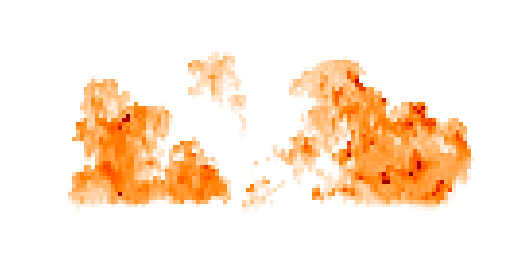

stdin


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


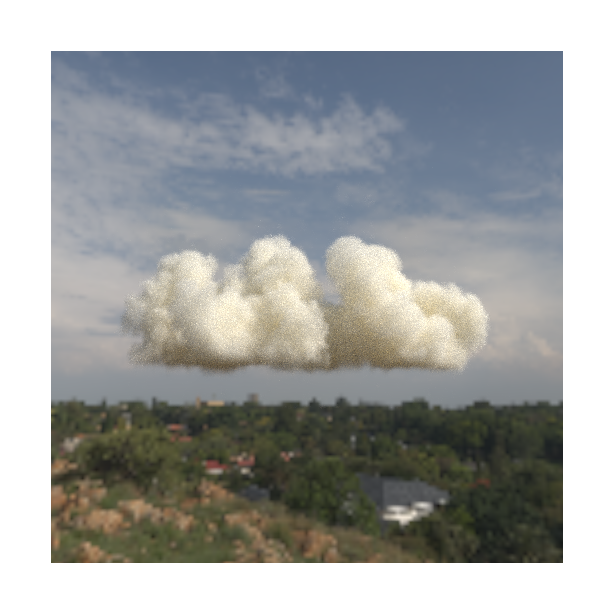

In [4]:
ref_latent = pipeline.get_test_latent(8)  

with torch.no_grad():
    ref_grid = pipeline.from_latent_to_grid(ref_latent).clamp_min(0.0)

show_slice(ref_grid)
render_as_cloud(ref_grid)

Let's define the method that will represent the downsampling of the volume grid.

In [5]:
def coarser_grid(g: torch.Tensor, levels: int) -> torch.Tensor:
    g = g.unsqueeze(0).permute(0, 4, 1, 2, 3)  # channels first
    for _ in range(levels):
        g = torch.nn.functional.interpolate(g, scale_factor=0.5, mode='trilinear', align_corners=True)
    return g.permute(0, 2, 3, 4, 1)[0]  # back to channels last

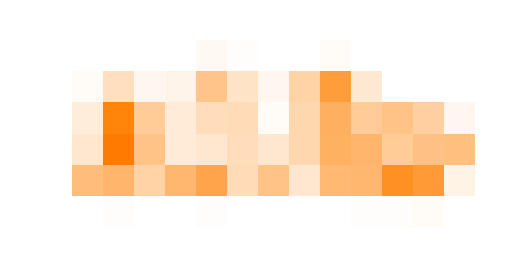

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


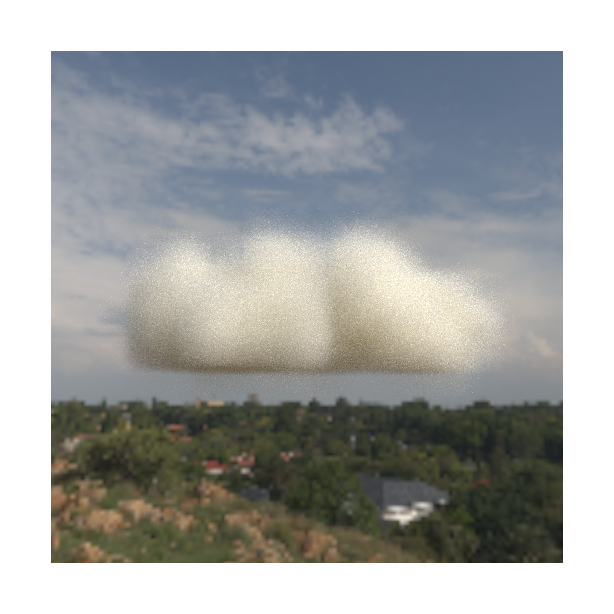

In [6]:
with torch.no_grad():
    coarse_grid = coarser_grid(ref_grid, 3)
    
show_slice(coarse_grid)

render_as_cloud(coarse_grid)

In [7]:
def criteria(latent):
    g = pipeline.from_latent_to_grid(latent, resolution=128).clamp_min(0.0)
    yhat = coarser_grid(g, 3)
    return ((coarse_grid - yhat) ** 2).sum() * (8 ** 3)

In [8]:
latent = pipeline.generate_latent(
    samples=300,
    scheduler_gamma=.4,
    criteria=criteria,
    criteria_scale=1.0
)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


Posterior sampling DPS_DDIM: 100%|██████████| 300/300 [01:08<00:00,  4.38it/s]


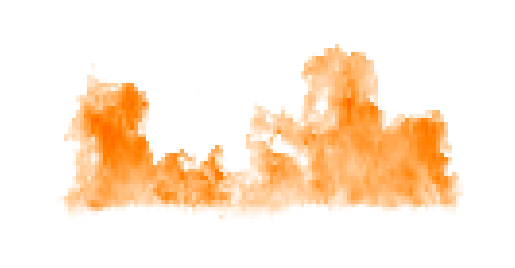

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


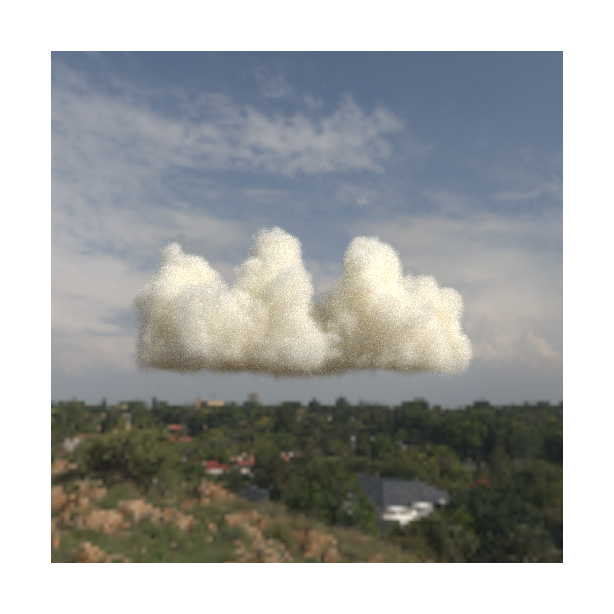

In [9]:
with torch.no_grad():
    inf_grid = pipeline.from_latent_to_grid(latent).clamp_min(0.0)

show_slice(inf_grid)

render_as_cloud(inf_grid)

In [14]:
latent = pipeline.generate_latent(
    samples=300,
    scheduler_gamma=.5,
    criteria=criteria,
    criteria_scale=0.2
)

Posterior sampling DPS_DDIM: 100%|██████████| 300/300 [01:08<00:00,  4.40it/s]


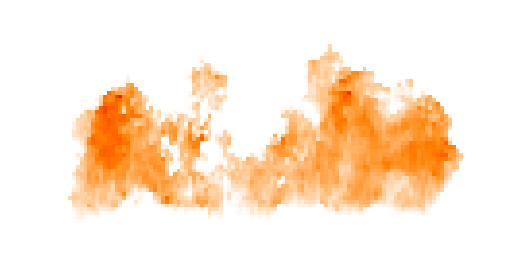

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


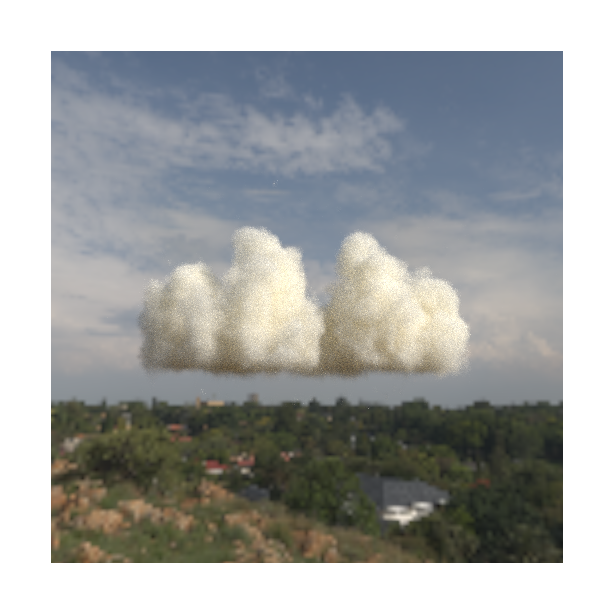

In [15]:
with torch.no_grad():
    inf_grid = pipeline.from_latent_to_grid(latent).clamp_min(0.0)

show_slice(inf_grid)

render_as_cloud(inf_grid)